In [26]:
!pip install torch torchvision fastai matplotlib
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 15.5 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install --upgrade fastai torchvision


In [3]:
from fastai.vision.all import untar_data, URLs

imagenette_path = untar_data(URLs.IMAGENETTE)
imagewoof_path = untar_data(URLs.IMAGEWOOF)

print(f"Imagenette path: {imagenette_path}")
print(f"Imagewoof path: {imagewoof_path}")

Imagenette path: /Users/sammizhu/.fastai/data/imagenette2
Imagewoof path: /Users/sammizhu/.fastai/data/imagewoof2


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create Datasets
imagenette_train_dataset = datasets.ImageFolder(imagenette_path/'train', transform=train_transforms)
imagenette_val_dataset = datasets.ImageFolder(imagenette_path/'val', transform=val_transforms)

imagewoof_train_dataset = datasets.ImageFolder(imagewoof_path/'train', transform=train_transforms)
imagewoof_val_dataset = datasets.ImageFolder(imagewoof_path/'val', transform=val_transforms)

# Create DataLoaders
batch_size = 32
imagenette_train_loader = DataLoader(imagenette_train_dataset, batch_size=batch_size, shuffle=True)
imagenette_val_loader = DataLoader(imagenette_val_dataset, batch_size=batch_size, shuffle=False)

imagewoof_train_loader = DataLoader(imagewoof_train_dataset, batch_size=batch_size, shuffle=True)
imagewoof_val_loader = DataLoader(imagewoof_val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
import torch
import torch.nn as nn
from torchvision import models

# Define the model (ResNet18 for example)
def create_model(num_classes):
    model = models.resnet18(pretrained=True)
    # Replace the final fully connected layer with the correct number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Imagenette and Imagewoof both have 10 classes
imagenette_model = create_model(num_classes=10)
imagewoof_model = create_model(num_classes=10)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/sammizhu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 16.6MB/s]


In [6]:
import torch.optim as optim

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam or SGD)
imagenette_optimizer = optim.Adam(imagenette_model.parameters(), lr=0.001)
imagewoof_optimizer = optim.Adam(imagewoof_model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model = model.to(device)
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        # Compute average loss for this epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validate the model
        val_acc = evaluate_model(model, val_loader)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Training complete. Best validation accuracy: {best_acc:.4f}")

# Function to evaluate the model
def evaluate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Update correct predictions
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    
    return correct / total


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model on Imagenette
print("Training on Imagenette dataset...")
train_model(imagenette_model, imagenette_train_loader, imagenette_val_loader, criterion, imagenette_optimizer, num_epochs=1)

# Train the model on Imagewoof
print("Training on Imagewoof dataset...")
train_model(imagewoof_model, imagewoof_train_loader, imagewoof_val_loader, criterion, imagewoof_optimizer, num_epochs=1)


Training on Imagenette dataset...
Epoch 1/1, Loss: 0.9318, Validation Accuracy: 0.7524
Training complete. Best validation accuracy: 0.7524
Training on Imagewoof dataset...
Epoch 1/1, Loss: 1.2682, Validation Accuracy: 0.7185
Training complete. Best validation accuracy: 0.7185


In [8]:
# Save the best model
torch.save(imagenette_model.state_dict(), 'imagenette_best_model.pth')
torch.save(imagewoof_model.state_dict(), 'imagewoof_best_model.pth')

# Load the models for inference
imagenette_model.load_state_dict(torch.load('imagenette_best_model.pth'))
imagewoof_model.load_state_dict(torch.load('imagewoof_best_model.pth'))


/var/folders/_c/2_16kg0x5s5_54m_2cvq27500000gn/T/ipykernel_49646/948871207.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  imagenette_model.load_state_dict(torch.load('i

<All keys matched successfully>

In [9]:
import torch
from torchvision import models

# Load your trained model (e.g., on Imagewoof)
model = models.resnet18(pretrained=False)
num_classes = 10 
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model.load_state_dict(torch.load('imagewoof_best_model.pth'))

model.eval()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/_c/2_16kg0x5s5_54m_2cvq27500000gn/T/ipykernel_49646/4214726901.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are exp

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# Dictionary to store activations for multiple layers
activations = {}

# Hook function to save activations from any layer
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output
    return hook

# Register hooks on all layers that are convolutional
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d):  # Only capture Conv2d layers
        layer.register_forward_hook(get_activation(name))


In [12]:
from PIL import Image
import torchvision.transforms as transforms

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and preprocess the dog image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0)
    return input_tensor, image

# Load the image of your dog
input_tensor, image = load_image('test_img/wangzai.jpeg')


In [13]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Move the input tensor to the device
input_tensor = input_tensor.to(device)

# Forward pass to get the model's output
output = model(input_tensor)

# Get the predicted class
target_class = output.argmax().item()

# Zero out any previous gradients
model.zero_grad()

# Backward pass to compute gradients for the target class
output[:, target_class].backward(retain_graph=True)


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the Grad-CAM heatmap
def grad_cam(activation, gradients):
    # Global average pooling over the gradients (average the gradients per feature map)
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Multiply each channel in the activation map by the pooled gradients
    for i in range(activation.size(1)):
        activation[:, i, :, :] *= pooled_gradients[i]

    # Create the heatmap by averaging the weighted activation maps
    heatmap = torch.mean(activation, dim=1).squeeze()

    # Apply ReLU to remove negative values
    heatmap = torch.relu(heatmap)

    # Normalize the heatmap between 0 and 1 for visualization
    heatmap -= heatmap.min()
    heatmap /= heatmap.max()

    return heatmap.detach().cpu().numpy()

# Function to visualize the heatmap overlayed on the original image with color
def visualize_heatmap(img, heatmap, alpha=0.5, colormap='jet'):
    # Resize heatmap to match the size of the original image
    heatmap = np.uint8(255 * heatmap)
    
    # Apply colormap to the heatmap
    colormap = plt.get_cmap(colormap)
    heatmap_colored = colormap(heatmap)
    
    # Remove the alpha channel from the colormap result (4th channel)
    heatmap_colored = np.delete(heatmap_colored, 3, axis=2)  # Drop alpha channel
    
    # Resize the colored heatmap to match the size of the original image
    heatmap_colored = Image.fromarray(np.uint8(heatmap_colored * 255))  # Convert to PIL image
    heatmap_colored = heatmap_colored.resize(img.size, Image.LANCZOS)  # Resize to match image size
    heatmap_colored = np.array(heatmap_colored)  # Convert back to numpy array
    
    # Convert original image to numpy array
    img = np.array(img)
    
    # Overlay the heatmap on the image with transparency
    overlay = np.uint8(img * (1 - alpha) + heatmap_colored * alpha)
    
    # Display the overlay
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


No gradients found for layer: conv1
No gradients found for layer: layer1.0.conv1
No gradients found for layer: layer1.0.conv2
No gradients found for layer: layer1.1.conv1
No gradients found for layer: layer1.1.conv2
Visualizing Grad-CAM for layer: layer2.0.conv1
Saved first Grad-CAM image to: test_img/gradcam.png


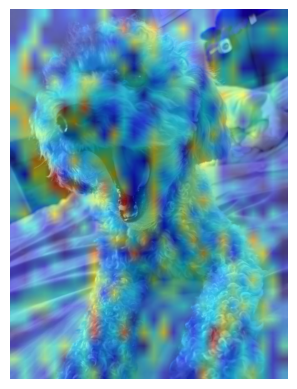

Visualizing Grad-CAM for layer: layer2.0.conv2


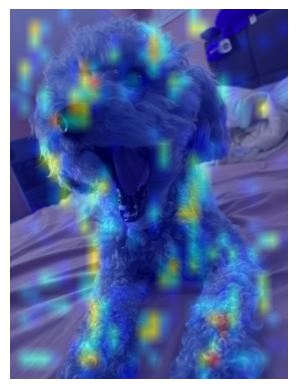

Visualizing Grad-CAM for layer: layer2.0.downsample.0


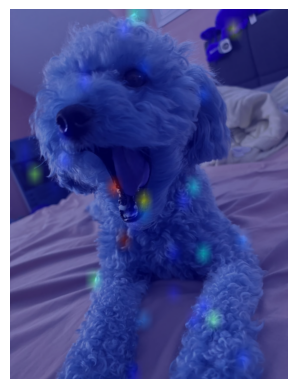

Visualizing Grad-CAM for layer: layer2.1.conv1


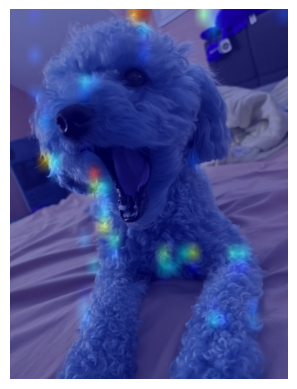

Visualizing Grad-CAM for layer: layer2.1.conv2


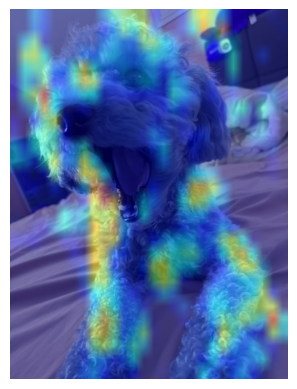

Visualizing Grad-CAM for layer: layer3.0.conv1


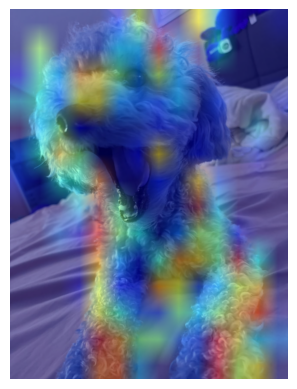

Visualizing Grad-CAM for layer: layer3.0.conv2


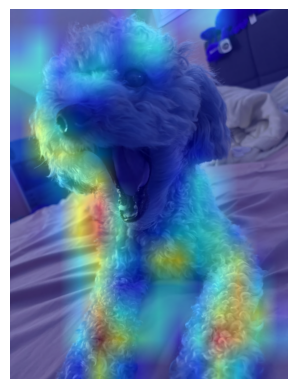

Visualizing Grad-CAM for layer: layer3.0.downsample.0


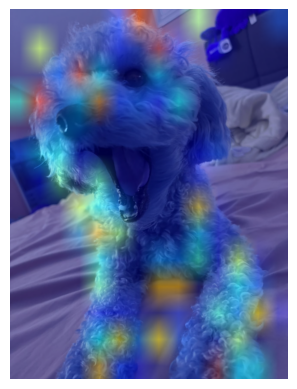

Visualizing Grad-CAM for layer: layer3.1.conv1


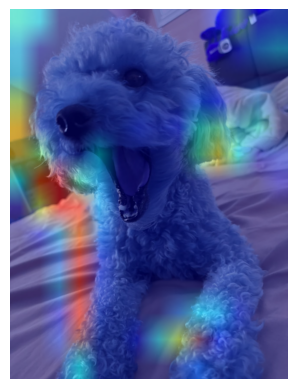

Visualizing Grad-CAM for layer: layer3.1.conv2


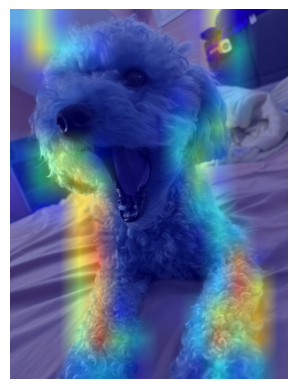

Visualizing Grad-CAM for layer: layer4.0.conv1


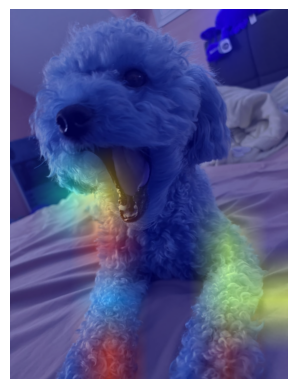

Visualizing Grad-CAM for layer: layer4.0.conv2


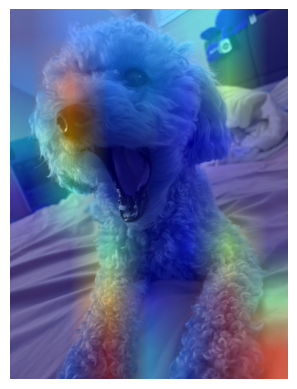

Visualizing Grad-CAM for layer: layer4.0.downsample.0


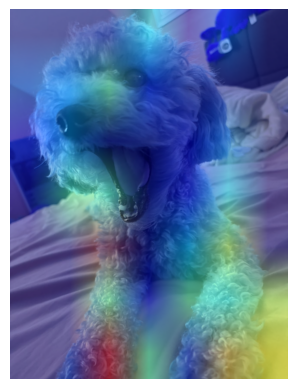

Visualizing Grad-CAM for layer: layer4.1.conv1


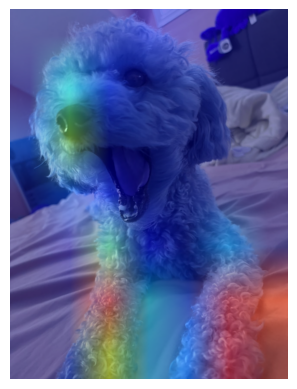

Visualizing Grad-CAM for layer: layer4.1.conv2


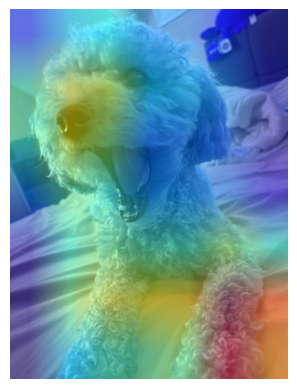

In [32]:
# # Generate Grad-CAM for each registered layer
# def generate_gradcam_for_all_layers(activations, target_class):
#     for layer_name, activation in activations.items():
#         # Compute the gradients for the activation
#         gradients = torch.autograd.grad(output[:, target_class], activation, retain_graph=True)[0]
        
#         # Generate the Grad-CAM heatmap
#         heatmap = grad_cam(activation, gradients)
        
#         # Visualize the heatmap with a colormap
#         print(f"Visualizing Grad-CAM for layer: {layer_name}")
#         visualize_heatmap(image, heatmap)

# # Generate and visualize Grad-CAM for all convolutional layers
# generate_gradcam_for_all_layers(activations, target_class)
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import Image

def grad_cam(activation, gradients):
    """Generate Grad-CAM heatmap."""
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # Global average pooling
    cam = torch.sum(weights * activation, dim=1).squeeze()  # Weighted sum
    cam = torch.clamp(cam, min=0)  # ReLU to keep positive values only
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Normalize to [0, 1]
    return cam.detach().cpu().numpy()  # Detach before converting to NumPy

def visualize_heatmap(image, heatmap):
    """Visualizes the Grad-CAM heatmap."""
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize to match

    overlay = cv2.addWeighted(heatmap, 0.5, image, 0.5, 0)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def generate_gradcam_for_all_layers(activations, target_class, image, output, save_first=True):
    first_saved = False  # Track first saved Grad-CAM
    for layer_name, activation in activations.items():
        try:
            # Compute gradients with allow_unused=True
            gradients = torch.autograd.grad(
                outputs=output[:, target_class], 
                inputs=activation, 
                retain_graph=True, 
                allow_unused=True
            )[0]

            if gradients is None:
                print(f"No gradients found for layer: {layer_name}")
                continue

            # Generate the Grad-CAM heatmap
            heatmap = grad_cam(activation, gradients)

            print(f"Visualizing Grad-CAM for layer: {layer_name}")

            # Convert image to NumPy if needed
            if isinstance(image, Image.Image):
                image_np = np.array(image)
            elif torch.is_tensor(image):
                image_np = image.detach().cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
            else:
                image_np = image

            image_np = np.uint8(255 * (image_np / image_np.max()))

            if len(image_np.shape) == 2 or image_np.shape[2] == 1:
                image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)

            if save_first and not first_saved:
                save_path = "test_img/gradcam.png"
                os.makedirs(os.path.dirname(save_path), exist_ok=True)

                heatmap_resized = cv2.resize(np.uint8(255 * heatmap), 
                                             (image_np.shape[1], image_np.shape[0]))
                heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

                overlay = cv2.addWeighted(heatmap_resized, 0.5, image_np, 0.5, 0)
                cv2.imwrite(save_path, overlay)
                print(f"Saved first Grad-CAM image to: {save_path}")

                first_saved = True

            visualize_heatmap(image_np, heatmap)

        except RuntimeError as e:
            print(f"Error processing layer {layer_name}: {str(e)}")

# Example usage
# Ensure `activations`, `target_class`, `image`, and `output` are defined
generate_gradcam_for_all_layers(activations, target_class, image, output)


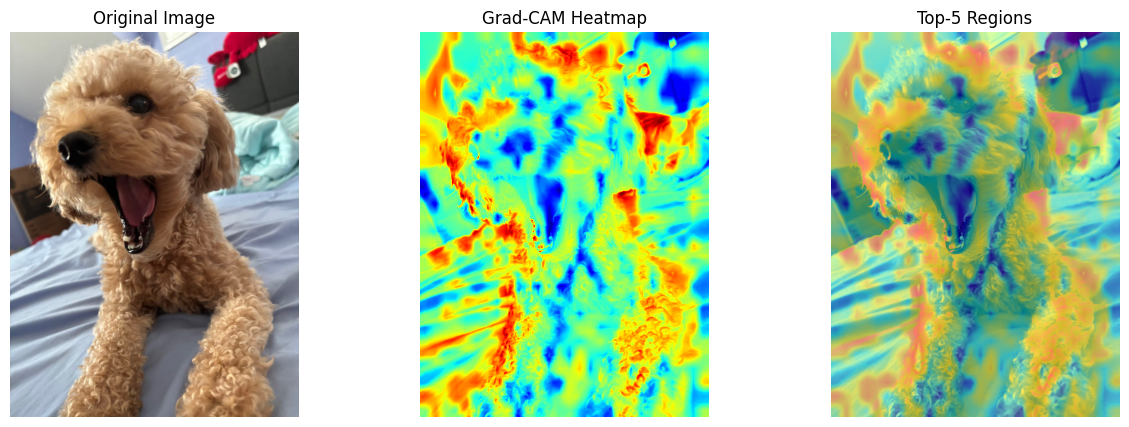

In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def show_top_k_regions_on_gradcam(grad_cam, original_image, top_k=5):
    """
    Displays only the Top-K regions on a Grad-CAM heatmap over the original image.
    
    Parameters:
    grad_cam (numpy array): The Grad-CAM heatmap (2D array, values between 0-1).
    original_image (numpy array): The original image (H x W x 3).
    top_k (int): The number of top regions to display based on intensity.
    """
    # Step 1: Normalize Grad-CAM to range [0, 255] for visualization.
    grad_cam_norm = np.uint8(255 * grad_cam)
    
    # Step 2: Threshold the Grad-CAM to extract Top-K regions.
    num_labels, labels_im = cv2.connectedComponents(grad_cam_norm)
    
    # Step 3: Measure the intensity of each connected component and sort.
    component_intensities = [
        (i, np.sum(grad_cam[labels_im == i])) for i in range(1, num_labels)
    ]
    top_k_components = sorted(component_intensities, key=lambda x: x[1], reverse=True)[:top_k]
    
    # Step 4: Create a mask to highlight only the Top-K regions.
    mask = np.zeros_like(grad_cam)
    for i, _ in top_k_components:
        mask[labels_im == i] = 1
    
    # Step 5: Apply the mask on the Grad-CAM heatmap.
    top_k_grad_cam = grad_cam * mask
    
    # Step 6: Overlay the Top-K heatmap on the original image.
    heatmap = cv2.applyColorMap(np.uint8(255 * top_k_grad_cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap, 0.5, original_image, 0.5, 0)
    
    # Step 7: Display the original image, Grad-CAM, and Top-K regions.
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(grad_cam, cmap='jet')
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f'Top-{top_k} Regions')
    plt.axis('off')
    
    plt.show()

# Example Usage:
# Load the Grad-CAM heatmap and original image as NumPy arrays.
grad_cam = cv2.imread("test_img/gradcam.png", cv2.IMREAD_GRAYSCALE) / 255.0  # Load as grayscale, normalize
original_image = cv2.imread("test_img/wangzai.jpeg")  # Load original image

# Ensure images are loaded correctly
if grad_cam is None or original_image is None:
    raise ValueError("One or both of the images could not be loaded. Check file paths.")

# Display the Top-K regions on the Grad-CAM.
show_top_k_regions_on_gradcam(grad_cam, original_image, top_k=5)